In [135]:
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import timeit
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

from sklearn import model_selection
from sklearn.experimental import enable_halving_search_cv
from sklearn import dummy
from sklearn import neighbors, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import kernel_ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from matplotlib.pyplot import subplots
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import re

In [137]:
#Importation de jeu de données :
data_globale=pd.read_csv("Seattle")

In [138]:
data = data_globale.copy()

In [139]:
X = data.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data["SiteEnergyUseWN(kBtu)"]
#répartition des données en données train et données test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)
#normaliser les données de sorte que les variables auront μ = 0 et σ = 1
std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)


### 1.Regression Dummy 

In [140]:
start_time = timeit.default_timer()
dum = dummy.DummyRegressor(strategy='mean')
dum.fit(X_train_std, y_train)

y_pred_dum = dum.predict(X_test_std)
temps_exec_Dummy = timeit.default_timer() - start_time

R2_Dummy = metrics.r2_score(y_test, y_pred_dum)
RMSE_Dummy = metrics.mean_squared_error(y_test, y_pred_dum,squared=False)
MAE_Dummy = metrics.mean_absolute_error(y_test, y_pred_dum)

print("R2 de l'algorithme Dummy sur le jeu de test : {:.2f}".format(metrics.r2_score(y_test, y_pred_dum)))
print("RMSE de l'algorithme Dummy sur le jeu de test : {:.2f}".format(metrics.mean_squared_error(y_test, y_pred_dum,squared=False)))
print("MAE de l'algorithme Dummy sur le jeu de test : {:.2f}".format(metrics.mean_absolute_error(y_test, y_pred_dum)))
print("Le temps d'execution de l'algorithme Dummy sur le jeu de test : {:.2f}s".format(temps_exec_Dummy))

R2 de l'algorithme Dummy sur le jeu de test : -0.00
RMSE de l'algorithme Dummy sur le jeu de test : 32459215.96
MAE de l'algorithme Dummy sur le jeu de test : 9703835.52
Le temps d'execution de l'algorithme Dummy sur le jeu de test : 0.01s


## 2. Regression Random Forest

In [141]:
param_grid = {'n_estimators': [10,100,500], 'max_features':['sqrt','log2'], 'max_depth':[5,10,20]}
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}
#score = ('r2','neg_mean_absolute_error','neg_root_mean_squared_error' )

model_forest = RandomForestRegressor(random_state=42)

start_time_forest = timeit.default_timer()
grid_pred_forest = model_selection.GridSearchCV(
    model_forest,
    param_grid,
    refit='r2',
    cv=5,  
    scoring= score)


grid_pred_forest.fit(X_train, y_train)

y_hat_forest = grid_pred_forest.predict(X_test)

temps_exec_forest = timeit.default_timer() - start_time_forest

In [142]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement de la cible TotalGHGEmissions:")
print(grid_pred_forest.best_params_)

print("Résultats de la validation croisée de la régression ridge pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_forest.cv_results_['mean_test_r2'], 
        grid_pred_forest.cv_results_['std_test_r2'], 
        grid_pred_forest.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )

    

#Le coefficient de détermination R2
R2_best_forest = max(grid_pred_forest.cv_results_['mean_test_r2'])
#La MAE moyenne arithmétique des valeurs absolues des écarts 
MAE_best_forest = min(grid_pred_forest.cv_results_['mean_test_neg_mean_absolute_error'])
#L'erreur quadratique 
RMSE_best_forest = min(grid_pred_forest.cv_results_['mean_test_neg_root_mean_squared_error'])


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement de la cible TotalGHGEmissions:
{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 500}
Résultats de la validation croisée de la régression ridge pour:
r2 = 0.609 (+/-0.033) for {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10}
r2 = 0.641 (+/-0.067) for {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
r2 = 0.637 (+/-0.074) for {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}
r2 = 0.564 (+/-0.128) for {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 10}
r2 = 0.592 (+/-0.067) for {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
r2 = 0.615 (+/-0.082) for {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 500}
r2 = 0.622 (+/-0.138) for {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}
r2 = 0.681 (+/-0.094) for {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
r2 = 0.693 (+/-0.100) for {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators':

In [143]:
print("- Voici les résultats obtenus avec l'algorithme Random Forest :")
print("Les meilleurs paramètres obtenus avec la méthode Random Forest sont", grid_pred_forest.best_params_)
RMSE_best_forest = min(grid_pred_forest.cv_results_['mean_test_neg_root_mean_squared_error'])
R2_best_forest = max(grid_pred_forest.cv_results_['mean_test_r2'])
MAE_best_forest = min(grid_pred_forest.cv_results_['mean_test_neg_mean_absolute_error'])
print("Le meilleur coefficient de détermination R2 : {:.2f}".format(R2_best_forest))
print("Le meilleur RMSE de l'algorithme : {:.2f}".format(RMSE_best_forest))
print("Le meilleur MAE de l'algorithme : {:.2f}".format(MAE_best_forest))
print("Le temps d'execution de l'algorithme  sur le jeu de test : {:.2f}s".format(temps_exec_forest))

- Voici les résultats obtenus avec l'algorithme Random Forest :
Les meilleurs paramètres obtenus avec la méthode Random Forest sont {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 500}
Le meilleur coefficient de détermination R2 : 0.70
Le meilleur RMSE de l'algorithme : 10109759.01
Le meilleur MAE de l'algorithme : 3423612.70
Le temps d'execution de l'algorithme  sur le jeu de test : 90.79s


### 3.Régression linéaire 

- Voici les résultats obtenus avec l'algorithme Linear Regression :
Coefficient de détermination R2  : 0.18
RMSE: 29343526.82
MAE : 5779943.38
Le temps d'execution de l'algorithme: 0.05s


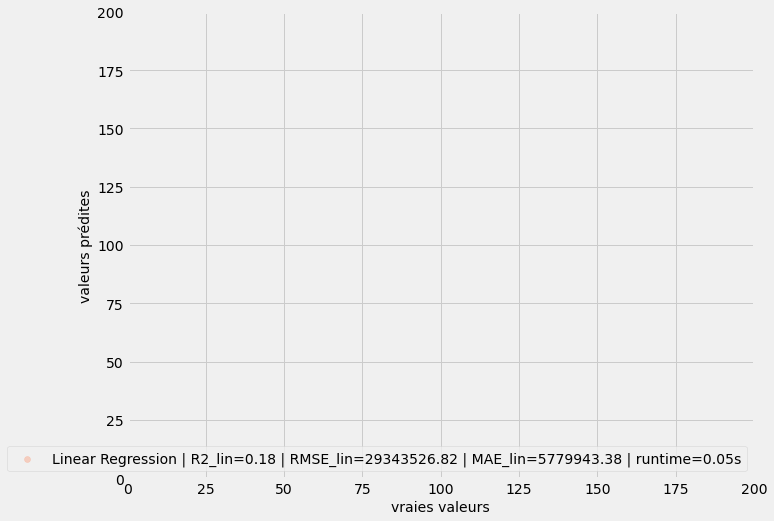

In [144]:
start_time = timeit.default_timer()
reg = LinearRegression().fit(X_train_std,y_train)
y_pred_reg = reg.predict(X_test_std)
temps_exec_lin = timeit.default_timer() - start_time 
#calculer le temps de l'éxecution de l'algorithme

R2_lin = metrics.r2_score(y_test, y_pred_reg)
RMSE_lin = metrics.mean_squared_error(y_test, y_pred_reg,squared=False)
MAE_lin = metrics.mean_absolute_error(y_test, y_pred_reg)

fig = plt.figure(figsize=(10,8))

plt.scatter(y_test,y_pred_reg,alpha=0.3,color='coral', label= "Linear Regression | R2_lin={:.2f} | RMSE_lin={:.2f} | MAE_lin={:.2f} | runtime={:.2f}s".format(R2_lin,RMSE_lin,MAE_lin,temps_exec_lin))
plt.ylim([0, 200])
plt.xlim([0, 200])
plt.xlabel('vraies valeurs', fontsize=14,)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right")

print("- Voici les résultats obtenus avec l'algorithme Linear Regression :")
print("Coefficient de détermination R2  : {:.2f}".format(metrics.r2_score(y_test, y_pred_reg)))
print("RMSE: {:.2f}".format(metrics.mean_squared_error(y_test, y_pred_reg,squared=False)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(y_test, y_pred_reg)))
print("Le temps d'execution de l'algorithme: {:.2f}s".format(temps_exec_lin))

L'algorithme de régression linéaire permet de prédire un peu mieux les émissions de CO2 par rapport à l'algorithme Dummy mais globalement les résultats des métriques ne sont pas bonnes

### 4.Régression Ridge / Ridge regression (modèle linéaire)

In [145]:
#On va tester Régression Ridge avec les parametres par defaut

In [146]:
grid_par_defaut = Ridge()
grid_par_defaut.fit(X_train_std, y_train)

y_pred_rdg_par_defaut = grid_par_defaut.predict(X_test_std)

temps_exec_Ridge1 = timeit.default_timer() - start_time
print("- Voici les résultats obtenus avec l'algorithme Ridge sur le test :")
print("Coefficient de détermination R2  : {:.2f}".format(metrics.r2_score(y_test, y_pred_rdg_par_defaut)))
print("RMSE: {:.2f}".format(metrics.mean_squared_error(y_test, y_pred_rdg_par_defaut,squared=False)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(y_test, y_pred_rdg_par_defaut)))
print("Le temps d'execution de l'algorithme: {:.2f}s".format(temps_exec_Ridge1))

- Voici les résultats obtenus avec l'algorithme Ridge sur le test :
Coefficient de détermination R2  : 0.18
RMSE: 29343947.76
MAE : 5780401.40
Le temps d'execution de l'algorithme: 0.68s


In [80]:
alpha_range = np.logspace(-2, 2, 5)

param_grid = {'alpha': alpha_range}

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}


start_time = timeit.default_timer()
grid_pred_rdg = model_selection.GridSearchCV(
        Ridge(random_state=42),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_rdg.fit(X_train_std, y_train)

y_pred_rdg = grid_pred_rdg.predict(X_test_std)

temps_exec_Ridge1 = timeit.default_timer() - start_time

In [81]:
print("Résultats de la validation croisée de la régression ridge pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_rdg.cv_results_['mean_test_r2'], 
        grid_pred_rdg.cv_results_['std_test_r2'], 
        grid_pred_rdg.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_pred_rdg.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_pred_rdg.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_pred_rdg.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_pred_rdg.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_pred_rdg.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_pred_rdg.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))

Résultats de la validation croisée de la régression ridge pour:
r2 = 0.640 (+/-0.114) for {'alpha': 0.01}
r2 = 0.640 (+/-0.114) for {'alpha': 0.1}
r2 = 0.640 (+/-0.114) for {'alpha': 1.0}
r2 = 0.644 (+/-0.111) for {'alpha': 10.0}
r2 = 0.667 (+/-0.086) for {'alpha': 100.0}
MAE = 4205258.160 (+/-365938.525) for {'alpha': 0.01}
MAE = 4204995.054 (+/-365976.658) for {'alpha': 0.1}
MAE = 4202369.249 (+/-366360.780) for {'alpha': 1.0}
MAE = 4177287.292 (+/-370358.422) for {'alpha': 10.0}
MAE = 4032957.214 (+/-432421.511) for {'alpha': 100.0}
RMSE = 10323768.233 (+/-2631262.516) for {'alpha': 0.01}
RMSE = 10323463.274 (+/-2631759.599) for {'alpha': 0.1}
RMSE = 10320434.291 (+/-2636725.373) for {'alpha': 1.0}
RMSE = 10292100.640 (+/-2685875.443) for {'alpha': 10.0}
RMSE = 10137243.982 (+/-3130045.422) for {'alpha': 100.0}


La régularisation Ridge permet une meilleur prédiction que la régression linéaire au niveau du résultat du RMSE

In [82]:
print("- Les résultats obtenus avec l'algorithme Kernel Ridge Regression en utilisant un noyau de type \n Radial Basis Function (RBF) :")
print("Les meilleurs paramètres obtenus sont", grid_pred_rdg.best_params_)
best_RMSE_Ridge1 = min(grid_pred_rdg.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2_Ridge1 = max(grid_pred_rdg.cv_results_['mean_test_r2'])
best_MAE_Ridge1 = min(grid_pred_rdg.cv_results_['mean_test_neg_mean_absolute_error'])
print("Le meilleur coefficient de détermination R2 : {:.2f}".format(best_R2_Ridge1))
print("Le meilleur RMSE: {:.2f}".format(best_RMSE_Ridge1))
print("Le meilleur MAE : {:.2f}".format(best_MAE_Ridge1))
print("Le temps d'execution de l'algorithme Kernel Ridge Regression sur le jeu de test : {:.2f}s".format(temps_exec_Ridge1))

- Les résultats obtenus avec l'algorithme Kernel Ridge Regression en utilisant un noyau de type 
 Radial Basis Function (RBF) :
Les meilleurs paramètres obtenus sont {'alpha': 100.0}
Le meilleur coefficient de détermination R2 : 0.67
Le meilleur RMSE: 10137243.98
Le meilleur MAE : 4032957.21
Le temps d'execution de l'algorithme Kernel Ridge Regression sur le jeu de test : 0.19s


### 5.Régression Ridge à noyau / Kernel Ridge regression ( Modèle non linéaire)

In [147]:
#On va tester Random Forest avec les parametres par defaut

In [148]:
from sklearn.kernel_ridge import KernelRidge


In [149]:
start_time = timeit.default_timer()
grid_pred_krdg = KernelRidge(alpha=1)
grid_pred_krdg.fit(X_train_std, y_train) #application de l'algorithme de prédiction sur les données train

y_pred_krdg_par_defaut = grid_pred_krdg.predict(X_test_std) #prédiction des valeurs des émissions avec les données test
temps_exec_Ridge2 = timeit.default_timer() - start_time #calcule du temps de d'éxecution de l'algorithme

print("- Voici les résultats obtenus avec l'algorithme Ridge sur le test  en utilisant les parametres par defaut:")
print("Coefficient de détermination R2  : {:.2f}".format(metrics.r2_score(y_test, y_pred_rdg_par_defaut)))
print("RMSE: {:.2f}".format(metrics.mean_squared_error(y_test, y_pred_rdg_par_defaut,squared=False)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(y_test, y_pred_rdg_par_defaut)))
print("Le temps d'execution de l'algorithme: {:.2f}s".format(temps_exec_Ridge1))

- Voici les résultats obtenus avec l'algorithme Ridge sur le test  en utilisant les parametres par defaut:
Coefficient de détermination R2  : 0.18
RMSE: 29343947.76
MAE : 5780401.40
Le temps d'execution de l'algorithme: 0.68s


Résultats de la validation croisée de la régression ridge à noyau pour:
r2 = 0.771 (+/-0.062) for {'alpha': 0.01, 'gamma': 0.01}
r2 = 0.198 (+/-0.140) for {'alpha': 0.01, 'gamma': 0.1}
r2 = -0.052 (+/-0.038) for {'alpha': 0.01, 'gamma': 1.0}
r2 = -0.213 (+/-0.080) for {'alpha': 0.01, 'gamma': 10.0}
r2 = 0.777 (+/-0.047) for {'alpha': 0.1, 'gamma': 0.01}
r2 = 0.203 (+/-0.150) for {'alpha': 0.1, 'gamma': 0.1}
r2 = -0.056 (+/-0.036) for {'alpha': 0.1, 'gamma': 1.0}
r2 = -0.214 (+/-0.081) for {'alpha': 0.1, 'gamma': 10.0}
r2 = 0.717 (+/-0.082) for {'alpha': 1.0, 'gamma': 0.01}
r2 = 0.163 (+/-0.134) for {'alpha': 1.0, 'gamma': 0.1}
r2 = -0.098 (+/-0.030) for {'alpha': 1.0, 'gamma': 1.0}
r2 = -0.220 (+/-0.085) for {'alpha': 1.0, 'gamma': 10.0}
r2 = 0.442 (+/-0.136) for {'alpha': 10.0, 'gamma': 0.01}
r2 = 0.005 (+/-0.042) for {'alpha': 10.0, 'gamma': 0.1}
r2 = -0.188 (+/-0.069) for {'alpha': 10.0, 'gamma': 1.0}
r2 = -0.228 (+/-0.091) for {'alpha': 10.0, 'gamma': 10.0}
r2 = 0.049 (+/-0.034) fo

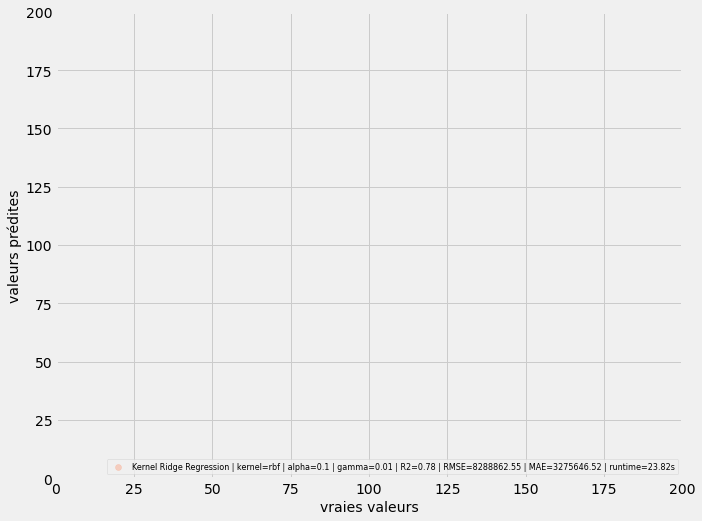

In [83]:
alpha_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 1, 4)
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}
#range des hyperparamètres à évaluer

score = {'r2':make_scorer(r2_score),\
         'neg_mean_absolute_error':make_scorer(mean_absolute_error),\
         'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}
#différents métriques utilisés

start_time = timeit.default_timer()
grid_pred_krdg = model_selection.GridSearchCV( # recherche des meilleurs hyperparamètres avec GridSearchGrid
        kernel_ridge.KernelRidge(kernel='rbf'),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_krdg.fit(X_train_std, y_train) #application de l'algorithme de prédiction sur les données train

y_pred_krdg = grid_pred_krdg.predict(X_test_std) #prédiction des valeurs des émissions avec les données test
temps_exec_Ridge2 = timeit.default_timer() - start_time #calcule du temps de d'éxecution de l'algorithme

print("Résultats de la validation croisée de la régression ridge à noyau pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_krdg.cv_results_['mean_test_r2'], 
        grid_pred_krdg.cv_results_['std_test_r2'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_pred_krdg.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_pred_krdg.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))
    
best_RMSE_Ridge2 = min(grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2_Ridge2 = max(grid_pred_krdg.cv_results_['mean_test_r2'])
best_MAE_Ridge2 = min(grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'])

fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_krdg,alpha=0.3,color='coral',label= "Kernel Ridge Regression | kernel=rbf | alpha=0.1 | gamma=0.01 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2_Ridge2,best_RMSE_Ridge2,best_MAE_Ridge2,temps_exec_Ridge2))
plt.xlim([0,200])
plt.ylim([0,200])
plt.xlabel('vraies valeurs', fontsize=14)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right", prop = {'size': 8})

In [84]:
print("- Voici les résultats obtenus avec l'algorithme Kernel Ridge Regression en utilisant un noyau de type \n Radial Basis Function (RBF) :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_pred_krdg.best_params_)
best_RMSE_Ridge2 = min(grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2_Ridge2 = max(grid_pred_krdg.cv_results_['mean_test_r2'])
best_MAE_Ridge2 = min(grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'])
print("Le meilleur coefficient de détermination R2 : {:.2f}".format(best_R2_Ridge2))
print("Le meilleur RMSE de l'algorithme : {:.2f}".format(best_RMSE_Ridge2))
print("Le meilleur MAE de l'algorithme : {:.2f}".format(best_MAE_Ridge2))
print("Le temps d'execution de l'algorithme sur le jeu de test : {:.2f}s".format(temps_exec_Ridge2))

- Voici les résultats obtenus avec l'algorithme Kernel Ridge Regression en utilisant un noyau de type 
 Radial Basis Function (RBF) :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'alpha': 0.1, 'gamma': 0.01}
Le meilleur coefficient de détermination R2 : 0.78
Le meilleur RMSE de l'algorithme : 8288862.55
Le meilleur MAE de l'algorithme : 3275646.52
Le temps d'execution de l'algorithme sur le jeu de test : 23.82s


### 6.Méthode des k plus proches voisins / k-nearest neighbors algorithm

In [150]:
#On va tester Régression Ridge avec les parametres par defaut

In [151]:
knn = neighbors.KNeighborsRegressor()
knn.fit(X_train_std, y_train)
y_pred_par_defaut = knn.predict(X_test_std)
print("- Voici les résultats obtenus avec l'algorithme k plus proches voisins par defaut sur le  jeu de test :")
print("Coefficient de détermination R2  : {:.2f}".format(metrics.r2_score(y_test, y_pred_par_defaut)))
print("RMSE: {:.2f}".format(metrics.mean_squared_error(y_test, y_pred_par_defaut,squared=False)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(y_test, y_pred_par_defaut)))

- Voici les résultats obtenus avec l'algorithme k plus proches voisins par defaut sur le  jeu de test :
Coefficient de détermination R2  : 0.09
RMSE: 30931549.40
MAE : 6300955.77


In [152]:
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}
start_time = timeit.default_timer()
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsRegressor(),
    param_grid,
    refit='r2',
    cv=5,           
    scoring=score)

clf.fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)
temps_exec_Knn = timeit.default_timer() - start_time

print("Meilleur hyperparamètre sur le jeu d'entraînement:")
print(clf.best_params_)
best_RMSE_knn = min(clf.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2_knn = max(clf.cv_results_['mean_test_r2'])
best_MAE_knn = min(clf.cv_results_['mean_test_neg_mean_absolute_error'])

print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_r2'], 
        clf.cv_results_['std_test_r2'],  
        clf.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean,
        std,
        params
    ) )
for mean_mae, std_mae, params in zip(
        clf.cv_results_['mean_test_neg_mean_absolute_error'], 
        clf.cv_results_['std_test_neg_mean_absolute_error'], 
        clf.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        clf.cv_results_['mean_test_neg_root_mean_squared_error'], 
        clf.cv_results_['std_test_neg_root_mean_squared_error'], 
        clf.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))

print("Le temps d'execution de l'algorithme sur le jeu de test : {:.2f}".format(temps_exec_Knn))   

Meilleur hyperparamètre sur le jeu d'entraînement:
{'n_neighbors': 11}
Résultats de la validation croisée :
r2 = 0.448 (+/-0.190) for {'n_neighbors': 3}
r2 = 0.545 (+/-0.136) for {'n_neighbors': 5}
r2 = 0.545 (+/-0.149) for {'n_neighbors': 7}
r2 = 0.554 (+/-0.070) for {'n_neighbors': 9}
r2 = 0.559 (+/-0.086) for {'n_neighbors': 11}
r2 = 0.551 (+/-0.099) for {'n_neighbors': 13}
r2 = 0.535 (+/-0.107) for {'n_neighbors': 15}
MAE = 4515186.257 (+/-495219.775) for {'n_neighbors': 3}
MAE = 4408794.203 (+/-510764.833) for {'n_neighbors': 5}
MAE = 4530616.276 (+/-608774.200) for {'n_neighbors': 7}
MAE = 4591866.942 (+/-696675.287) for {'n_neighbors': 9}
MAE = 4621502.893 (+/-757917.815) for {'n_neighbors': 11}
MAE = 4643934.230 (+/-769190.472) for {'n_neighbors': 13}
MAE = 4684471.662 (+/-793546.079) for {'n_neighbors': 15}
RMSE = 12332861.762 (+/-1826309.148) for {'n_neighbors': 3}
RMSE = 11595193.249 (+/-3068235.911) for {'n_neighbors': 5}
RMSE = 11856599.535 (+/-4010133.365) for {'n_neighbo

In [86]:
print("Voici les résultats obtenus avec l'algorithme KNN Regressor :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", clf.best_params_)
print("Le meilleur coefficient de détermination R2 de l'algorithme KNN sur le jeu de test : {:.2f}".format(best_R2_knn))
print("Le meilleur RMSE de l'algorithme KNN sur le jeu de test : {:.2f}".format(best_RMSE_knn))
print("Le meilleur MAE de l'algorithme KNN sur le jeu de test : {:.2f}".format(best_MAE_knn))
print("Le temps d'execution de l'algorithme KNN sur le jeu de test : {:.2f}s".format(temps_exec_Knn))

Voici les résultats obtenus avec l'algorithme KNN Regressor :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'n_neighbors': 11}
Le meilleur coefficient de détermination R2 de l'algorithme KNN sur le jeu de test : 0.56
Le meilleur RMSE de l'algorithme KNN sur le jeu de test : 11595193.25
Le meilleur MAE de l'algorithme KNN sur le jeu de test : 4408794.20
Le temps d'execution de l'algorithme KNN sur le jeu de test : 0.65s


**Le modèle KNN nous donne un résultat plus intéressant au niveau de l'écart quadratique moyen RMSE pour lequel on observe une diminution importante par rapport au modèles Ridge**

### 7.L'algorithme du gradient boosting / Gradient Boosting Regressor

In [153]:
#On va tester Régression Ridge avec les parametres par defaut

In [159]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [162]:
boosting_par_defaut =  GradientBoostingRegressor()
boosting_par_defaut.fit(X_train_std, y_train)

y_pred_xboost_par_defaut = boosting_par_defaut.predict(X_test_std)
print("- Voici les résultats obtenus avec l'algorithme  gradient boosting  par defaut sur le  jeu de test :")
print("Coefficient de détermination R2  : {:.2f}".format(metrics.r2_score(y_test, y_pred_xboost_par_defaut)))
print("RMSE: {:.2f}".format(metrics.mean_squared_error(y_test, y_pred_xboost_par_defaut,squared=False)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(y_test, y_pred_xboost_par_defaut)))

- Voici les résultats obtenus avec l'algorithme  gradient boosting  par defaut sur le  jeu de test :
Coefficient de détermination R2  : 0.23
RMSE: 28503807.35
MAE : 4965197.92


Les meilleurs paramètres de l'algorithme XGBoost sur le jeu d'entraînement sont {'learning_rate': 0.04, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.5}
Résultats de la validation croisée de le boost gradient pour:
r2 = 0.566 (+/-0.085) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.613 (+/-0.082) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
r2 = 0.542 (+/-0.116) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.1}
r2 = 0.645 (+/-0.105) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
r2 = 0.712 (+/-0.044) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
r2 = 0.666 (+/-0.089) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.1}
r2 = 0.615 (+/-0.117) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.630 (+/-0.103) for {'learning_rate': 

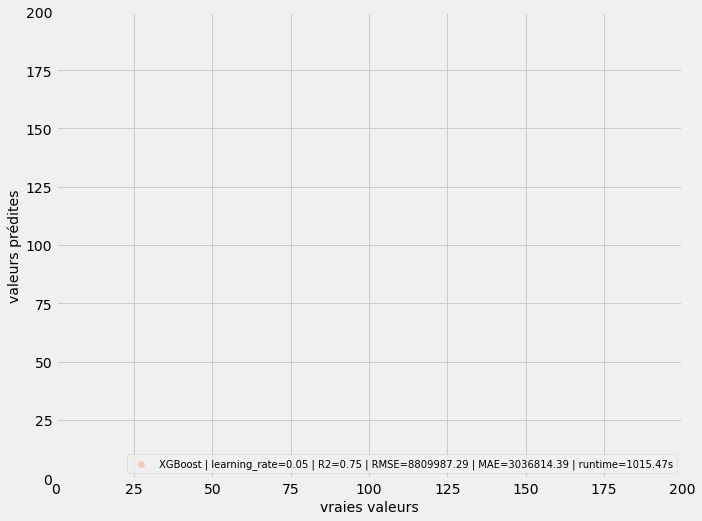

In [163]:
subsample = [0.9,0.5,0.1]
n_estimators = [100,200]
max_depth = [3,5,8,10]
learning_range = np.arange(0.01,0.11,0.01)

param_grid = {'max_depth':max_depth,'learning_rate':learning_range,'subsample':subsample,'n_estimators':n_estimators}

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}


start_time = timeit.default_timer()
grid_pred_xboost = model_selection.GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_xboost.fit(X_train_std, y_train)

y_pred_xboost = grid_pred_xboost.predict(X_test_std)

temps_exec_boost = timeit.default_timer() - start_time

print ("Les meilleurs paramètres de l'algorithme XGBoost sur le jeu d'entraînement sont",grid_pred_xboost.best_params_)
print("Résultats de la validation croisée de le boost gradient pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_xboost.cv_results_['mean_test_r2'], 
        grid_pred_xboost.cv_results_['std_test_r2'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_pred_xboost.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_pred_xboost.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_pred_xboost.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_pred_xboost.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))

best_RMSE_boost = min(grid_pred_xboost.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2_boost = max(grid_pred_xboost.cv_results_['mean_test_r2'])
best_MAE_boost = min(grid_pred_xboost.cv_results_['mean_test_neg_mean_absolute_error'])

fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred_xboost,alpha=0.3,color='coral',label= "XGBoost | learning_rate=0.05 | R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}s".format(best_R2_boost,best_RMSE_boost,best_MAE_boost,temps_exec_boost))
plt.xlim([0,200])
plt.ylim([0,200])
plt.xlabel('vraies valeurs', fontsize=14)
plt.ylabel('valeurs prédites', fontsize=14)
plt.legend(loc="lower right", prop = {'size': 10})

In [88]:
print("Les résultats obtenus avec l'algorithme gradient boost Regression :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_pred_xboost.best_params_)
print("Le meilleur coefficient de détermination R2 : {:.2f}".format(best_R2_boost))
print("Le meilleur RMSE : {:.2f}".format(best_RMSE_boost))
print("Le meilleur MAE  : {:.2f}".format(best_MAE_boost))
print("Le temps d'execution de l'algorithme : {:.2f}s".format(temps_exec_boost))

Les résultats obtenus avec l'algorithme gradient boost Regression :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'learning_rate': 0.04, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.5}
Le meilleur coefficient de détermination R2 : 0.75
Le meilleur RMSE : 8809987.29
Le meilleur MAE  : 3036814.39
Le temps d'execution de l'algorithme : 1045.81s


### 8.Support vector regression (SVR) à noyau linéaire (modèle linéaire)

In [164]:
#On va tester support vector regression a noyeau lineaire avec les parametres par defaut

In [165]:
svr_par_defaut = SVR()
svr_par_defaut.fit(X_train_std, y_train)
y_pred_svr_par_defaut = grid_svr.predict(X_test_std)
print("- Voici les résultats obtenus avec l'algorithme  Support vector regression (SVR)  par defaut sur le  jeu de test :")
print("Coefficient de détermination R2  : {:.2f}".format(metrics.r2_score(y_test, y_pred_svr_par_defaut)))
print("RMSE: {:.2f}".format(metrics.mean_squared_error(y_test, y_pred_svr_par_defaut,squared=False)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(y_test, y_pred_svr_par_defaut)))

- Voici les résultats obtenus avec l'algorithme  Support vector regression (SVR)  par defaut sur le  jeu de test :
Coefficient de détermination R2  : -0.04
RMSE: 33113918.41
MAE : 8239352.30


In [89]:
c_range = np.logspace(-2, 2, 6)
gamma_range = np.logspace(-2, 2, 6)
tuned_parameters = [{'kernel': ['linear'], 'C': c_range,'gamma':gamma_range}]

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}

svr = SVR()
grid_svr = model_selection.GridSearchCV(svr,param_grid=tuned_parameters,refit="r2",cv=5,scoring=score)
grid_svr.fit(X_train_std, y_train)
y_pred_svr = grid_svr.predict(X_test_std)
temps_exec_svr1 = timeit.default_timer() - start_time

print("Résultats de la validation croisée de l'algorithme SVR pour:")
for mean_r2, std_r2, params in zip(
        grid_svr.cv_results_['mean_test_r2'], 
        grid_svr.cv_results_['std_test_r2'], 
        grid_svr.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_svr.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_svr.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_svr.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_svr.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_svr.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_svr.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))
    
best_RMSE_svr1 = min(grid_svr.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2_svr1 = max(grid_svr.cv_results_['mean_test_r2'])
best_MAE_svr1 = min(grid_svr.cv_results_['mean_test_neg_mean_absolute_error'])

Résultats de la validation croisée de l'algorithme SVR pour:
r2 = -0.094 (+/-0.032) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}
r2 = -0.094 (+/-0.032) for {'C': 0.01, 'gamma': 0.06309573444801933, 'kernel': 'linear'}
r2 = -0.094 (+/-0.032) for {'C': 0.01, 'gamma': 0.3981071705534973, 'kernel': 'linear'}
r2 = -0.094 (+/-0.032) for {'C': 0.01, 'gamma': 2.5118864315095824, 'kernel': 'linear'}
r2 = -0.094 (+/-0.032) for {'C': 0.01, 'gamma': 15.848931924611142, 'kernel': 'linear'}
r2 = -0.094 (+/-0.032) for {'C': 0.01, 'gamma': 100.0, 'kernel': 'linear'}
r2 = -0.094 (+/-0.032) for {'C': 0.06309573444801933, 'gamma': 0.01, 'kernel': 'linear'}
r2 = -0.094 (+/-0.032) for {'C': 0.06309573444801933, 'gamma': 0.06309573444801933, 'kernel': 'linear'}
r2 = -0.094 (+/-0.032) for {'C': 0.06309573444801933, 'gamma': 0.3981071705534973, 'kernel': 'linear'}
r2 = -0.094 (+/-0.032) for {'C': 0.06309573444801933, 'gamma': 2.5118864315095824, 'kernel': 'linear'}
r2 = -0.094 (+/-0.032) for {'C': 0.063

In [90]:
print("Les résultats obtenus avec l'algorithme SVR :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_svr.best_params_)
print("Le meilleur coefficient de détermination R2: {:.2f}".format(best_R2_svr1))
print("Le meilleur RMSE: {:.2f}".format(best_RMSE_svr1))
print("Le meilleur MAE: {:.2f}".format(best_MAE_svr1))
print("Le temps d'execution de l'algorithme SVR sur le jeu de test : {:.2f}".format(temps_exec_svr1))   

Les résultats obtenus avec l'algorithme SVR :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'C': 100.0, 'gamma': 0.01, 'kernel': 'linear'}
Le meilleur coefficient de détermination R2: -0.08
Le meilleur RMSE: 18543483.68
Le meilleur MAE: 6369515.24
Le temps d'execution de l'algorithme SVR sur le jeu de test : 1073.98


### 9.Support vector regression (SVR) à noyau rbf (modèle non linéaire)

In [166]:
#On va tester support vector regression a noyeau rbf avec les parametres par defaut

In [167]:
svr_par_defaut = SVR()
svr_par_defaut.fit(X_train_std, y_train)
y_pred_svr_par_defaut = grid_svr.predict(X_test_std)
print("- Voici les résultats obtenus avec l'algorithme  Support vector regression (SVR)  par defaut sur le  jeu de test :")
print("Coefficient de détermination R2  : {:.2f}".format(metrics.r2_score(y_test, y_pred_svr_par_defaut)))
print("RMSE: {:.2f}".format(metrics.mean_squared_error(y_test, y_pred_svr_par_defaut,squared=False)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(y_test, y_pred_svr_par_defaut)))

- Voici les résultats obtenus avec l'algorithme  Support vector regression (SVR)  par defaut sur le  jeu de test :
Coefficient de détermination R2  : -0.04
RMSE: 33113918.41
MAE : 8239352.30


In [91]:
c_range = np.logspace(-2, 2, 6)
gamma_range = np.logspace(-2, 2, 6)
tuned_parameters = [{'kernel': ['rbf'], 'C': c_range,'gamma':gamma_range}]

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}

svr = SVR()
grid_svr2 = model_selection.GridSearchCV(svr,param_grid=tuned_parameters,refit="r2",cv=5,scoring=score)
grid_svr2.fit(X_train_std, y_train)
y_pred_svr = grid_svr2.predict(X_test_std)
temps_exec_svr2 = timeit.default_timer() - start_time

print("Résultats de la validation croisée de l'algorithme SVR pour:")
for mean_r2, std_r2, params in zip(
        grid_svr2.cv_results_['mean_test_r2'], 
        grid_svr2.cv_results_['std_test_r2'], 
        grid_svr2.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_svr2.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_svr2.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_svr2.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_svr2.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_svr2.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_svr2.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))


best_RMSE_svr2 = min(grid_svr2.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2_svr2 = max(grid_svr2.cv_results_['mean_test_r2'])
best_MAE_svr2 = min(grid_svr2.cv_results_['mean_test_neg_mean_absolute_error'])


Résultats de la validation croisée de l'algorithme SVR pour:
r2 = -0.094 (+/-0.032) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
r2 = -0.094 (+/-0.032) for {'C': 0.01, 'gamma': 0.06309573444801933, 'kernel': 'rbf'}
r2 = -0.094 (+/-0.032) for {'C': 0.01, 'gamma': 0.3981071705534973, 'kernel': 'rbf'}
r2 = -0.094 (+/-0.032) for {'C': 0.01, 'gamma': 2.5118864315095824, 'kernel': 'rbf'}
r2 = -0.094 (+/-0.032) for {'C': 0.01, 'gamma': 15.848931924611142, 'kernel': 'rbf'}
r2 = -0.094 (+/-0.032) for {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'}
r2 = -0.094 (+/-0.032) for {'C': 0.06309573444801933, 'gamma': 0.01, 'kernel': 'rbf'}
r2 = -0.094 (+/-0.032) for {'C': 0.06309573444801933, 'gamma': 0.06309573444801933, 'kernel': 'rbf'}
r2 = -0.094 (+/-0.032) for {'C': 0.06309573444801933, 'gamma': 0.3981071705534973, 'kernel': 'rbf'}
r2 = -0.094 (+/-0.032) for {'C': 0.06309573444801933, 'gamma': 2.5118864315095824, 'kernel': 'rbf'}
r2 = -0.094 (+/-0.032) for {'C': 0.06309573444801933, 'gamma': 15.84

In [93]:
print("Les résultats obtenus avec l'algorithme SVR :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_svr.best_params_)
print("Le meilleur coefficient R2: {:.2f}".format(best_R2_svr2))
print("Le meilleur RMSE: {:.2f}".format(best_RMSE_svr2))
print("Le meilleur MAE: {:.2f}".format(best_MAE_svr2))
print("Le temps d'execution de l'algorithme SVR sur le jeu de test : {:.2f}s".format(temps_exec_svr2))   

Les résultats obtenus avec l'algorithme SVR :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'C': 100.0, 'gamma': 0.01, 'kernel': 'linear'}
Le meilleur coefficient R2: -0.09
Le meilleur RMSE: 18618259.80
Le meilleur MAE: 6440097.80
Le temps d'execution de l'algorithme SVR sur le jeu de test : 1131.27s


Text(0, 0.5, 'R2')

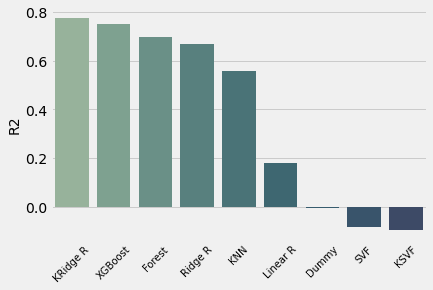

In [95]:
CO2_results_R2 = pd.DataFrame(np.array([[R2_Dummy,R2_best_forest,R2_lin,best_R2_Ridge1,best_R2_Ridge2,best_R2_knn,best_R2_boost,best_R2_svr1,best_R2_svr2]]), columns=["Dummy","Forest","Linear R","Ridge R","KRidge R","KNN","XGBoost","SVF","KSVF"])
CO2_results_R2=CO2_results_R2.sort_values(by=0,ascending=False,axis=1)
CO2_results_R2 = CO2_results_R2.T
CO2_results_R2.columns = ['R2']
sns.barplot(x = CO2_results_R2.index,y = CO2_results_R2["R2"],saturation=.5,palette="crest")
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("R2",fontsize=14)

Text(0, 0.5, 'RMSE')

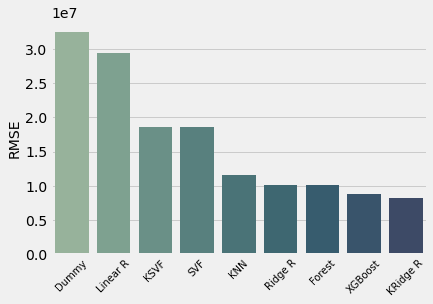

In [96]:
CO2_results_RMSE = pd.DataFrame(np.array([[RMSE_Dummy,RMSE_best_forest,RMSE_lin,best_RMSE_Ridge1,best_RMSE_Ridge2,best_RMSE_knn,best_RMSE_boost,best_RMSE_svr1,best_RMSE_svr2]]), columns=["Dummy","Forest","Linear R","Ridge R","KRidge R","KNN","XGBoost","SVF","KSVF"])
CO2_results_RMSE=CO2_results_RMSE.sort_values(by=0,ascending=False,axis=1)
CO2_results_RMSE = CO2_results_RMSE.T
CO2_results_RMSE.columns = ['RMSE']
sns.barplot(x = CO2_results_RMSE.index,y = CO2_results_RMSE["RMSE"],saturation=.5,palette="crest")
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("RMSE",fontsize=14)

Text(0, 0.5, 'MAE')

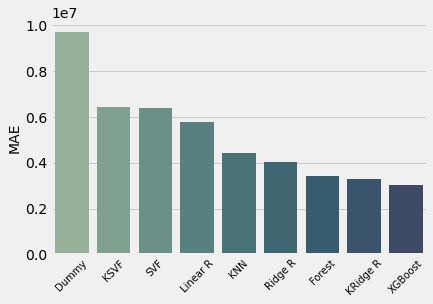

In [97]:
CO2_results_MAE = pd.DataFrame(np.array([[MAE_Dummy,MAE_best_forest,MAE_lin,best_MAE_Ridge1,best_MAE_Ridge2,best_MAE_knn,best_MAE_boost,best_MAE_svr1,best_MAE_svr2]]), columns=["Dummy","Forest","Linear R","Ridge R","KRidge R","KNN","XGBoost","SVF","KSVF"])
CO2_results_MAE=CO2_results_MAE.sort_values(by=0,ascending=False,axis=1)
CO2_results_MAE = CO2_results_MAE.T
CO2_results_MAE.columns = ['MAE']
sns.barplot(x = CO2_results_MAE.index,y = CO2_results_MAE["MAE"],saturation=.5,palette="crest")
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("MAE",fontsize=14)

Text(0, 0.5, 'Runtime')

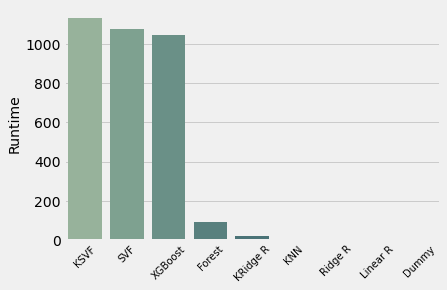

In [98]:
CO2_results_runtime = pd.DataFrame(np.array([[temps_exec_Dummy,temps_exec_forest,temps_exec_lin,temps_exec_Ridge1,temps_exec_Ridge2,temps_exec_Knn,temps_exec_boost,temps_exec_svr1,temps_exec_svr2]]), columns=["Dummy","Forest","Linear R","Ridge R","KRidge R","KNN","XGBoost","SVF","KSVF"])
CO2_results_runtime=CO2_results_runtime.sort_values(by=0,ascending=False,axis=1)
CO2_results_runtime = CO2_results_runtime.T
CO2_results_runtime.columns = ['Runtime']
sns.barplot(x = CO2_results_runtime.index,y = CO2_results_runtime["Runtime"],saturation=.5,palette="crest")
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Runtime",fontsize=14)

In [131]:
Data_performance_s = pd.DataFrame({'RMSE':[RMSE_Dummy,RMSE_best_forest,RMSE_lin,best_RMSE_Ridge1,best_RMSE_Ridge2,best_RMSE_knn,best_RMSE_boost,best_RMSE_svr1,best_RMSE_svr2],
                              'R2':[R2_Dummy,R2_best_forest,R2_lin,best_R2_Ridge1,best_R2_Ridge2,best_R2_knn,best_R2_boost,best_R2_svr1,best_R2_svr2],
                              'MAE':[MAE_Dummy,MAE_best_forest,MAE_lin,best_MAE_Ridge1,best_MAE_Ridge2,best_MAE_knn,best_MAE_boost,best_MAE_svr1,best_MAE_svr2],
                              'Temps':[temps_exec_Dummy,temps_exec_forest,temps_exec_lin,temps_exec_Ridge1,temps_exec_Ridge2,temps_exec_Knn,temps_exec_boost,temps_exec_svr1,temps_exec_svr2]},
                             index = ["Dummy","Forest","Linear R","Ridge R","KRidge R","KNN","XGBoost","SVF","KSVF"])

In [132]:
Data_performance_s

,RMSE,R2,MAE,Temps
Dummy,3.245922e+07,-0.004075,9.703836e+06,0.006104
Forest,1.010976e+07,0.697362,3.423613e+06,92.530485
Linear R,2.934353e+07,0.179431,5.779943e+06,0.055904
Ridge R,1.013724e+07,0.667374,4.032957e+06,0.192567
KRidge R,9.306366e+06,0.712734,3.809568e+06,23.247437
KNN,1.159519e+07,0.559416,4.408794e+06,0.650561
XGBoost,8.809987e+06,0.750880,3.036814e+06,1045.810832
SVF,1.854348e+07,-0.083650,6.369515e+06,1073.977027
KSVF,1.861826e+07,-0.093514,6.440098e+06,1131.271520


In [171]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

In [173]:
from sklearn.model_selection import learning_curve

## ENERGYSTARScore

In [99]:
X = data.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)","ENERGYSTARScore"],axis=1)
y = data["SiteEnergyUseWN(kBtu)"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

Résultats de la validation croisée de la régression ridge à noyau pour:
r2 = 0.677 (+/-0.144) for {'alpha': 0.01, 'gamma': 0.01}
r2 = 0.121 (+/-0.072) for {'alpha': 0.01, 'gamma': 0.1}
r2 = -0.014 (+/-0.024) for {'alpha': 0.01, 'gamma': 1.0}
r2 = -0.187 (+/-0.061) for {'alpha': 0.01, 'gamma': 10.0}
r2 = 0.713 (+/-0.072) for {'alpha': 0.1, 'gamma': 0.01}
r2 = 0.157 (+/-0.072) for {'alpha': 0.1, 'gamma': 0.1}
r2 = -0.010 (+/-0.024) for {'alpha': 0.1, 'gamma': 1.0}
r2 = -0.187 (+/-0.061) for {'alpha': 0.1, 'gamma': 10.0}
r2 = 0.673 (+/-0.064) for {'alpha': 1.0, 'gamma': 0.01}
r2 = 0.138 (+/-0.071) for {'alpha': 1.0, 'gamma': 0.1}
r2 = -0.051 (+/-0.015) for {'alpha': 1.0, 'gamma': 1.0}
r2 = -0.201 (+/-0.070) for {'alpha': 1.0, 'gamma': 10.0}
r2 = 0.416 (+/-0.109) for {'alpha': 10.0, 'gamma': 0.01}
r2 = 0.010 (+/-0.035) for {'alpha': 10.0, 'gamma': 0.1}
r2 = -0.165 (+/-0.055) for {'alpha': 10.0, 'gamma': 1.0}
r2 = -0.225 (+/-0.083) for {'alpha': 10.0, 'gamma': 10.0}
r2 = 0.047 (+/-0.031) fo

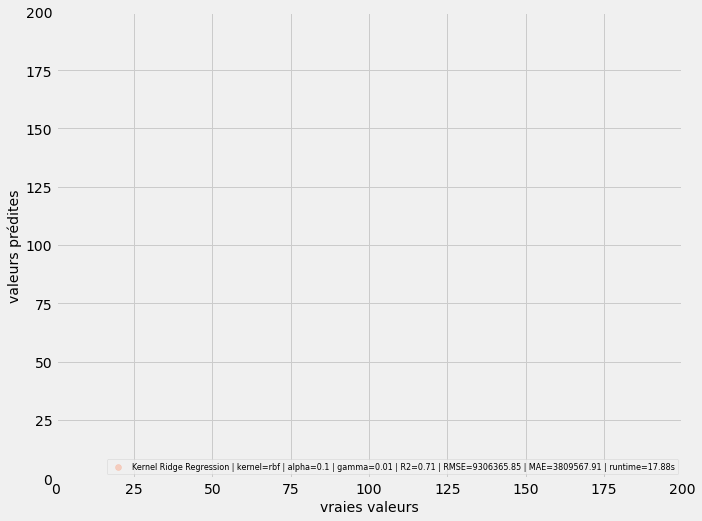

In [100]:
alpha_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 1, 4)
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}
#range des hyperparamètres à évaluer

score = {'r2':make_scorer(r2_score),\
         'neg_mean_absolute_error':make_scorer(mean_absolute_error),\
         'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}
#différents métriques utilisés
/
start_time = timeit.default_timer()
grid_pred_krdg = model_selection.GridSearchCV( # recherche des meilleurs hyperparamètres avec GridSearchGrid
        kernel_ridge.KernelRidge(kernel='rbf'),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_krdg.fit(X_train_std, y_train) #application de l'algorithme de prédiction sur les données train

y_pred_krdg = grid_pred_krdg.predict(X_test_std) #prédiction des valeurs des émissions avec les données test
temps_exec_Ridge2 = timeit.default_timer() - start_time #calcule du temps de d'éxecution de l'algorithme

print("Résultats de la validation croisée de la régression ridge à noyau pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_krdg.cv_results_['mean_test_r2'], 
        grid_pred_krdg.cv_results_['std_test_r2'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_pred_krdg.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_pred_krdg.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))
    
best_RMSE = min(grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_pred_krdg.cv_results_['mean_test_r2'])
best_MAE = min(grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'])


In [101]:
print("- Voici les résultats obtenus avec l'algorithme Kernel Ridge Regression en utilisant un noyau de type \n Radial Basis Function (RBF) :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_pred_krdg.best_params_)
best_RMSE_Ridge2 = min(grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2_Ridge2 = max(grid_pred_krdg.cv_results_['mean_test_r2'])
best_MAE_Ridge2 = min(grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'])
print("Le meilleur coefficient de détermination R2 : {:.2f}".format(best_R2_Ridge2))
print("Le meilleur RMSE de l'algorithme : {:.2f}".format(best_RMSE_Ridge2))
print("Le meilleur MAE de l'algorithme : {:.2f}".format(best_MAE_Ridge2))
print("Le temps d'execution de l'algorithme sur le jeu de test : {:.2f}s".format(temps_exec_Ridge2))

- Voici les résultats obtenus avec l'algorithme Kernel Ridge Regression en utilisant un noyau de type 
 Radial Basis Function (RBF) :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'alpha': 0.1, 'gamma': 0.01}
Le meilleur coefficient de détermination R2 : 0.71
Le meilleur RMSE de l'algorithme : 9306365.85
Le meilleur MAE de l'algorithme : 3809567.91
Le temps d'execution de l'algorithme sur le jeu de test : 17.88s


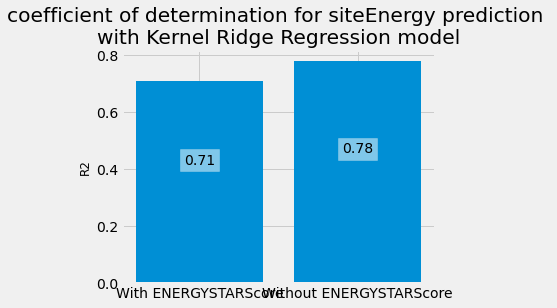

In [176]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]/1.7,y[i], ha = 'center',
                 bbox = dict(facecolor = 'white', alpha = .5))
        
if __name__ == '__main__':
    
    x = ["With ENERGYSTARScore","Without ENERGYSTARScore"]
    y = [0.71,0.78]
      
    plt.figure(figsize = (5,4))
    plt.bar(x, y)
      
    addlabels(x, y)
      
    plt.title("coefficient of determination for siteEnergy prediction \nwith Kernel Ridge Regression model")
      
    plt.ylabel("R2",fontsize=12)      
    plt.show()

## Amélioration du feature engineering

In [103]:
#analyse de coefficient de symétrie

In [104]:
# Mis en l'échelle logarithmetique
from sklearn.preprocessing import FunctionTransformer

In [169]:
X = data.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"],axis=1)
y = data["SiteEnergyUseWN(kBtu)"]
#répartition des données en données train et données test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)
#normaliser les données de sorte que les variables auront μ = 0 et σ = 1
std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

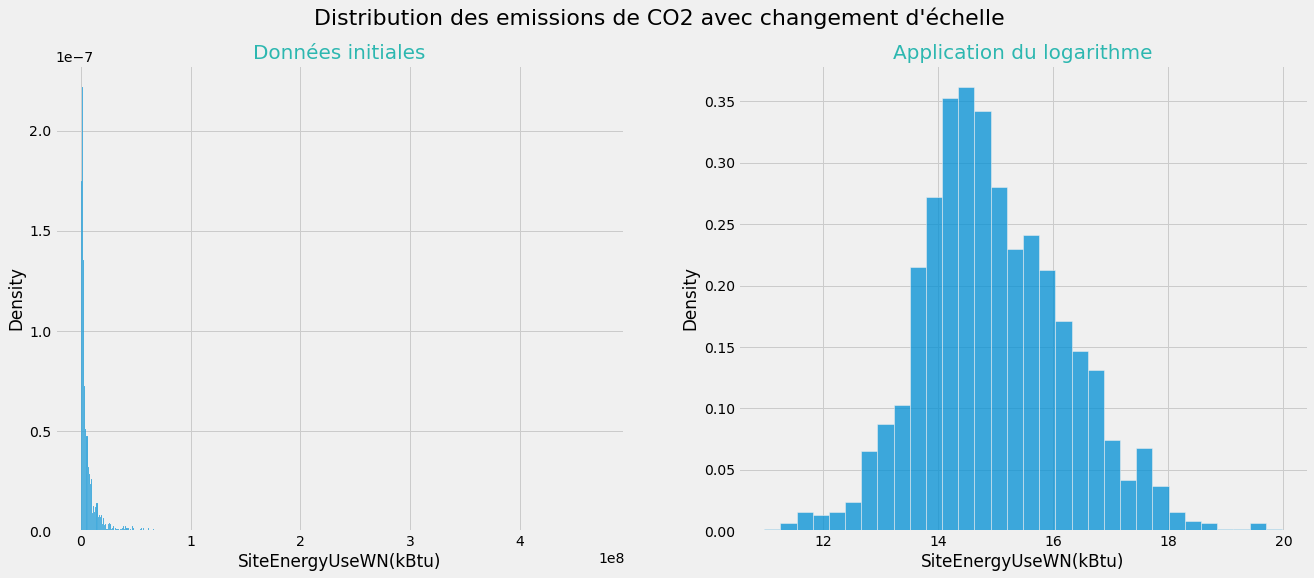

In [170]:
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(y)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=y, stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0', fontsize=20)
sns.histplot(data=Y_log, stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0', fontsize=20)
plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontsize=22)
plt.show()

In [106]:
data_log = data.copy()

In [107]:
test_co2 = np.log2(1+data_log['TotalGHGEmissions'])
test_site = np.log2(1+data_log['SiteEnergyUseWN(kBtu)'])

In [108]:
data_log['Log2-TotalGHGEmissions'] = test_co2
data_log['Log2-SiteEnergyUseWN(kBtu)'] = test_site

In [109]:
X_log = data_log.drop(['Log2-TotalGHGEmissions', 'Log2-SiteEnergyUseWN(kBtu)'], axis = 1)
y_log = data_log['Log2-SiteEnergyUseWN(kBtu)']

In [110]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size = 0.20)
print('X_train_log shape:', X_train.shape)
print('X_test_log shape:', X_test.shape)
print('y_train_log shape:', y_train.shape)
print('y_test_log shape:', y_test.shape)


X_train_log shape: (1216, 35)
X_test_log shape: (406, 35)
y_train_log shape: (1216,)
y_test_log shape: (406,)


In [111]:
#Starditsation des features 
std = StandardScaler().fit(X_train_log)
X_train_std = std.transform(X_train_log)
X_test_log_std = std.transform(X_test_log)

In [112]:
alpha_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 1, 4)
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}
#range des hyperparamètres à évaluer

score = {'r2':make_scorer(r2_score),\
         'neg_mean_absolute_error':make_scorer(mean_absolute_error),\
         'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False)}
#différents métriques utilisés
/
start_time = timeit.default_timer()
grid_pred_krdg = model_selection.GridSearchCV( # recherche des meilleurs hyperparamètres avec GridSearchGrid
        kernel_ridge.KernelRidge(kernel='rbf'),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_krdg.fit(X_train_std, y_train_log) #application de l'algorithme de prédiction sur les données train

y_pred_krdg = grid_pred_krdg.predict(X_test_log_std ) #prédiction des valeurs des émissions avec les données test
temps_exec_Ridge2 = timeit.default_timer() - start_time #calcule du temps de d'éxecution de l'algorithme

print("Résultats de la validation croisée de la régression ridge à noyau pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_krdg.cv_results_['mean_test_r2'], 
        grid_pred_krdg.cv_results_['std_test_r2'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )
for mean_mae, std_mae, params in zip(
        grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'], 
        grid_pred_krdg.cv_results_['std_test_neg_mean_absolute_error'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_mae,
        std_mae,
        params
    ))
for mean_rmse, std_rmse, params in zip(
        grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'], 
        grid_pred_krdg.cv_results_['std_test_neg_root_mean_squared_error'], 
        grid_pred_krdg.cv_results_['params']           
    ):

    print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
        mean_rmse,
        std_rmse,
        params
    ))
    
best_RMSE = min(grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_pred_krdg.cv_results_['mean_test_r2'])
best_MAE = min(grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'])

Résultats de la validation croisée de la régression ridge à noyau pour:
r2 = 0.410 (+/-0.352) for {'alpha': 0.01, 'gamma': 0.01}
r2 = -8.077 (+/-1.426) for {'alpha': 0.01, 'gamma': 0.1}
r2 = -56.682 (+/-6.083) for {'alpha': 0.01, 'gamma': 1.0}
r2 = -124.111 (+/-12.993) for {'alpha': 0.01, 'gamma': 10.0}
r2 = 0.357 (+/-0.380) for {'alpha': 0.1, 'gamma': 0.01}
r2 = -8.727 (+/-1.513) for {'alpha': 0.1, 'gamma': 0.1}
r2 = -58.540 (+/-6.276) for {'alpha': 0.1, 'gamma': 1.0}
r2 = -124.856 (+/-13.057) for {'alpha': 0.1, 'gamma': 10.0}
r2 = -0.089 (+/-0.361) for {'alpha': 1.0, 'gamma': 0.01}
r2 = -13.431 (+/-1.911) for {'alpha': 1.0, 'gamma': 0.1}
r2 = -72.221 (+/-7.757) for {'alpha': 1.0, 'gamma': 1.0}
r2 = -129.691 (+/-13.508) for {'alpha': 1.0, 'gamma': 10.0}
r2 = -2.694 (+/-0.316) for {'alpha': 10.0, 'gamma': 0.01}
r2 = -39.929 (+/-5.171) for {'alpha': 10.0, 'gamma': 0.1}
r2 = -109.252 (+/-11.148) for {'alpha': 10.0, 'gamma': 1.0}
r2 = -137.379 (+/-14.221) for {'alpha': 10.0, 'gamma': 10.0

In [113]:
print("- Voici les résultats obtenus avec l'algorithme Kernel Ridge Regression en utilisant un noyau de type \n Radial Basis Function (RBF) :")
print("Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont", grid_pred_krdg.best_params_)
best_RMSE = min(grid_pred_krdg.cv_results_['mean_test_neg_root_mean_squared_error'])
best_R2 = max(grid_pred_krdg.cv_results_['mean_test_r2'])
best_MAE = min(grid_pred_krdg.cv_results_['mean_test_neg_mean_absolute_error'])
print("Le meilleur coefficient de détermination R2 : {:.2f}".format(best_R2))
print("Le meilleur RMSE de l'algorithme : {:.2f}".format(best_RMSE))
print("Le meilleur MAE de l'algorithme : {:.2f}".format(best_MAE))


- Voici les résultats obtenus avec l'algorithme Kernel Ridge Regression en utilisant un noyau de type 
 Radial Basis Function (RBF) :
Les meilleurs paramètres obtenus avec la méthode GridSearchCV sont {'alpha': 0.01, 'gamma': 0.01}
Le meilleur coefficient de détermination R2 : 0.41
Le meilleur RMSE de l'algorithme : 1.36
Le meilleur MAE de l'algorithme : 0.62


In [114]:
param_grid = {'n_estimators': [10,100,500], 'max_features':['sqrt','log2'], 'max_depth':[5,10,20]}
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}
#score = ('r2','neg_mean_absolute_error','neg_root_mean_squared_error' )

model_forest = RandomForestRegressor(random_state=42)

start_time_forest = timeit.default_timer()
grid_pred_forest = model_selection.GridSearchCV(
    model_forest,
    param_grid,
    refit='r2',
    cv=5,  
    scoring= score)


grid_pred_forest.fit(X_train_std, y_train_log)

y_hat_forest = grid_pred_forest.predict(X_test_log_std)

temps_time_forest = timeit.default_timer() - start_time_forest

In [115]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(grid_pred_forest.best_params_)

print("Résultats de la validation croisée de la régression svr pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_forest.cv_results_['mean_test_r2'], 
        grid_pred_forest.cv_results_['std_test_r2'], 
        grid_pred_forest.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 500}
Résultats de la validation croisée de la régression svr pour:
r2 = 0.904 (+/-0.012) for {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10}
r2 = 0.907 (+/-0.014) for {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
r2 = 0.907 (+/-0.013) for {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}
r2 = 0.885 (+/-0.022) for {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 10}
r2 = 0.880 (+/-0.018) for {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
r2 = 0.877 (+/-0.017) for {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 500}
r2 = 0.961 (+/-0.004) for {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}
r2 = 0.967 (+/-0.006) for {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
r2 = 0.969 (+/-0.006) for {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}
r2 = 0.952 (+/-0.007) for 

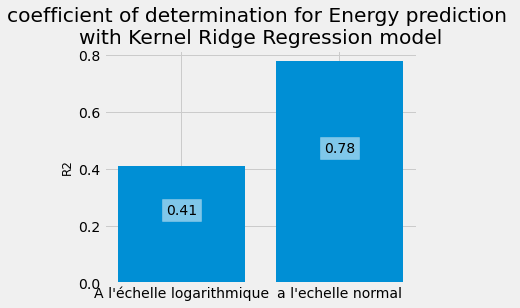

In [175]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]/1.7,y[i], ha = 'center',
                 bbox = dict(facecolor = 'white', alpha = .5))
        
if __name__ == '__main__':
    
    x = ["A l'échelle logarithmique","a l'echelle normal"]
    y = [0.41,0.78]
      
    plt.figure(figsize = (5,4))
    plt.bar(x, y)
      
    addlabels(x, y)
      
    plt.title("coefficient of determination for Energy prediction \nwith Kernel Ridge Regression model")
      
    plt.ylabel("R2",fontsize=12)      
    plt.show()

In [117]:
model = RandomForestRegressor()
# Fits the model on the data
model.fit(X_train, y_train)

RandomForestRegressor()

In [118]:
model = RandomForestRegressor(n_estimators = 500, max_features='sqrt', max_depth=20, random_state= 42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=500,
                      random_state=42)

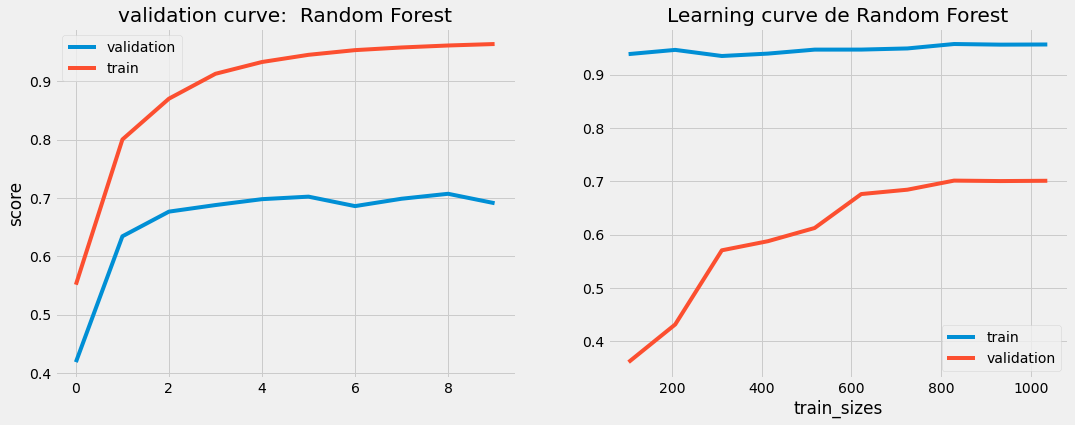

In [177]:
fig = plt.figure(1, figsize=(25, 6))



rf = RandomForestRegressor(random_state=42)


plt.subplot(131)
train_scores, valid_scores = validation_curve(rf,X_train, y_train,
                                              param_name="max_depth",
                                              param_range=np.arange(1, 11), cv=5)
plt.plot(valid_scores.mean(axis=1), label='validation')
plt.plot(train_scores.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel(' ')
plt.title("validation curve:  Random Forest")
plt.legend()

plt.subplot(132)
model_forest = grid_pred_forest.best_estimator_
train_sizes, train_scores, valid_scores = learning_curve(model_forest, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)
#print(train_sizes)
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Learning curve de Random Forest')
plt.legend()

In [119]:
importances = model.feature_importances_

In [120]:
liste_variables = list((data.drop(['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)'], axis = 1)).columns)

Text(0.5, 0, 'Relative Importance')

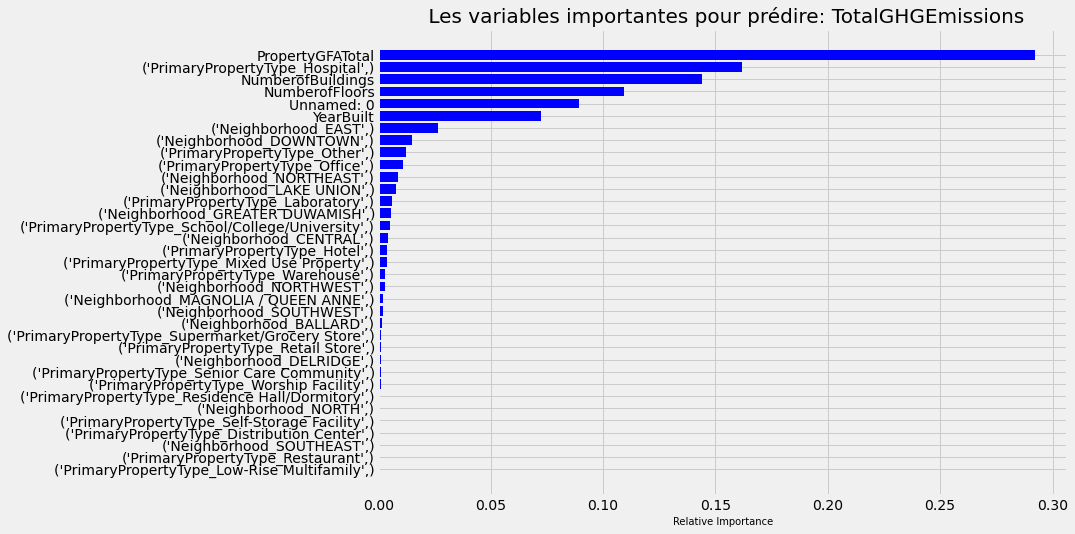

In [121]:
indices = np.argsort(importances)
# style du graphique 
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,8)) 
plt.title(' Les variables importantes pour prédire: TotalGHGEmissions', fontsize=20)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance', fontsize=10)

In [122]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [123]:
import shap
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [124]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 407it [42:01,  6.27s/it]                            


In [125]:
shap_values

.values =
array([[ 1608708.38587035,    37231.55438969,        0.        , ...,
          -36154.83241201,   638750.60257459,  -171008.55233559],
       [ -709517.56922769,    20984.0900889 ,        0.        , ...,
          -33982.20007425,  -121736.17532283, -2122168.69174483],
       [ -714375.06132932,    21292.93849238,        0.        , ...,
          -28110.34224247,  -598166.91100918, -2436471.09184507],
       ...,
       [  983517.06876063,    20889.71475064,        0.        , ...,
          -35269.51148496,  -763666.33258869, -1841863.31533476],
       [   93873.24519239,    19117.13470927,        0.        , ...,
          -16768.19682183, -1063312.53940617, -3184641.37795647],
       [ -185944.25087976,  -755686.50796619,        0.        , ...,
          -21486.81435256,  -594647.5300955 ,  3776659.12874825]])

.base_values =
array([6573850.9575453, 6573850.9575453, 6573850.9575453, 6573850.9575453,
       6573850.9575453, 6573850.9575453, 6573850.9575453, 6573850.9575

## Résumé global


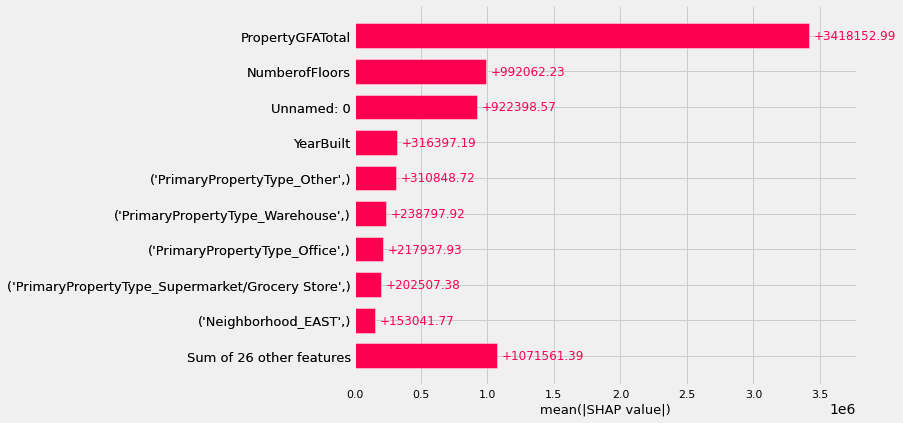

In [126]:
shap.plots.bar(shap_values)

## Résumé de l’intrigue: beeswarm

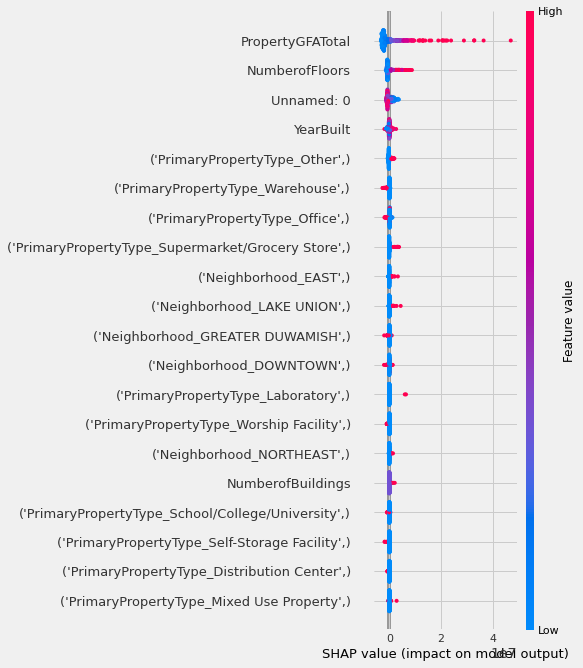

In [127]:
shap.summary_plot(shap_values)

In [128]:
shap.summary_plot

<function shap.plots._beeswarm.summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x000001EDE200B2E0>, auto_size_plot=None, use_log_scale=False)>

## Tracage d'une seule instance

## Parcelle en cascade

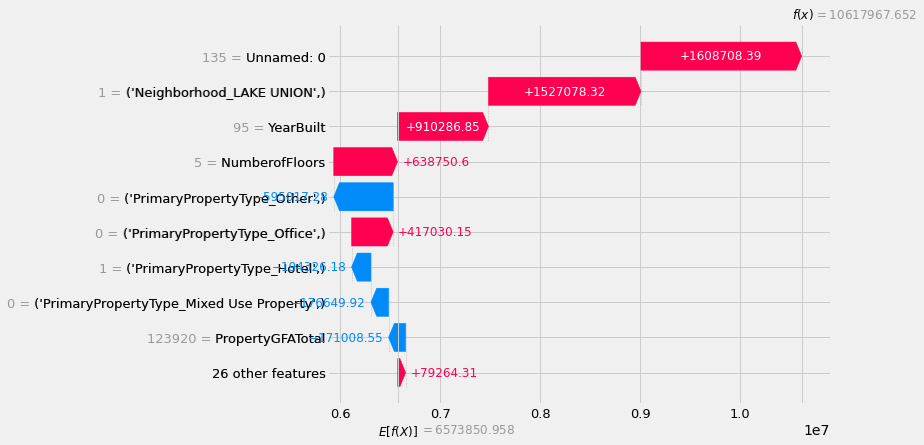

In [129]:
shap.plots.waterfall(shap_values[0])